# 次元圧縮(dimensionality reduction)

次元圧縮を行う目的は主に以下の二つがあげられる。

 - データの圧縮
 - データの可視化


## 目次

[2.5. Decomposing signals in components (matrix factorization problems) — scikit-learn 0.19.0 documentation](http://scikit-learn.org/stable/modules/decomposition.html#)


 1. 主成分分析(principal component analysis: **PCA**)
 2. インクリメンタル主成分分析(Incremental PCA)
 3. ランダム化SVDを用いた主成分分析(PCA using randomized SVD)
 4. カーネル主成分分析(Kernel PCA)
 5. Sparse principal components analysis (SparsePCA and MiniBatchSparsePCA)
     - スパース主成分分析(Sparse principal components analysis: **SparsePCA**)
     - ミニバッチスパース主成分分析(Mini Batch Sparse principal components analysis: **MiniBatchSparsePCA**)
 6. TruncatedSVD(Truncated singular value decomposition and latent semantic analysis)
 7. 要因分析(**Factor Analysis**)
 8. 潜在的ディリクレ配分法(Latent Dirichlet Allocation: **LDA**)

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

%matplotlib inline

---
# 主成分分析(principal component analysis: PCA) 

以下、*「多変量解析法入門」(ライブラリ新数学大系)より*

主成分分析とは、相関のある多数の変数から相関のない少数で全体のばらつきを最もよく表す主成分と呼ばれる変数を合成する多変量解析の一手法。データの次元を削減するために用いられる。

## 解析ストーリー

> 1. 相関係数行列$R$の第1固有値(最大固有値)${ \lambda }_{ 1 }$に対応する固有ベクトルから**第1主成分$z_{1}$**を求める。次に$R$の第2固有値${ \lambda }_{ 2 }$に対応する固有ベクトルから**第2主成分$z_{2}$**を求める。同様にして、**第$k$主成分**を求める。($k=3,4,\cdots, p$)
> 2. それぞれの主成分の**寄与率**および**累積寄与率**を求める。「固有値が1以上」ないしは「累積寄与率が80%を超える」を目安として主成分を選択する。
> 3. **因子負荷量**を求める。固有ベクトルや因子負荷量の値を参考にして、選択した各主成分の意味について考察する。また、因子負荷量を散布図にプロットし、変数の分類を行う。
> 4. **主成分得点**を散布図にプロットし、サンプルの特徴付けや分類を行う。


### 1. 主成分の導出
変数$x_{1}$と$x_{2}$を標準化する。
$$
u_{1} = \frac {x_{1} - \bar {x_{1}} }{ \widehat { \sigma_{1} } }, \quad u_{2} = \frac {x_{2} - \bar {x_{2}}}{ \widehat { \sigma_{2} } }\\
\widehat { \sigma_{i} } = \frac {1}{n-1}\sum _{i=1}^{n}{\left(x_{i} - \bar {x}\right)^{2}}
$$
また、後のため、次のことにも注意しておく。
$$
\sum _{i=1}^{n}{{u_{i1}}^{2}} = \sum _{i=1}^{n}{{u_{i2}}^{2}} = n-1 \quad (9.2)
$$
証明
$$
\sum { \left( \frac { { x }_{ i }-\bar { x }  }{ \widehat { \sigma  }  }  \right) ^{ 2 } } =\frac { \left( n-1 \right) { \widehat { \sigma  }  }^{ 2 } }{ { \widehat { \sigma  }  }^{ 2 } } =n-1
$$

\---------

$$
\sum _{i=1}^{n}{ u_{i1}u_{i2} } = (n-1)r_{x_{1}x_{2}} \quad (9.3)
$$
証明
$$
\widehat { \sigma _{ x_{ 1 }x_{ 2 } } } = \frac { 1 }{ n-1 } \sum { \left( { x }_{ i1 }-\bar { x }  \right) \left( { x }_{ i2 }-\bar { x }  \right)  }より\\
\sum _{ i=1 }^{ n }{ u_{ i1 }u_{ i2 } } =\sum { \left( \frac { { x }_{ i1 }-\bar { { x }_{ 1 } }  }{ \widehat { { \sigma  }_{ 1 } }  }  \right) \left( \frac { { x }_{ i2 }-\bar { { x }_{ 2 } }  }{ \widehat { { \sigma  }_{ 2 } }  }  \right)  } =\frac { \left( n-1 \right) \widehat { \sigma _{ x_{ 1 }x_{ 2 } } }  }{ \widehat { { \sigma  }_{ 1 } } \cdot \widehat { { \sigma  }_{ 2 } }  } =\left( n-1 \right) { r }_{ { x }_{ 1 }{ x }_{ 2 } }
$$

**第1主成分$z_{1}$**を
$$
z_{1} = a_{1}u_{1} + a_{2}u_{2} \quad (9.4)
$$
とおく。標準化変量$u_{1},u_{2}$の平均値は0なので、第1主成分の平均値も0である。
$$
E\left(z_{1}\right) = a_{1}E\left(u_{1}\right) + a_{2}E\left(u_{2}\right) = a_{1}\cdot0 + a_{2}\cdot0 = 0 \quad (9.5)
$$
目的は、データの情報をできるだけ多く有するように$z_{1}$を定めることである(つまり、係数$a_{1}$と$a_{2}$をデータから定めることである)。

　「$z_{1}$がもとのデータの情報をできるだけ多く有する」ということを「データの全体のばらつきをできるだけ$z_{1}$のばらつきに反映させる」と考える。すなわち、$z_{1}$の分散
$$
V_{z_{1}} = \frac {1}{n-1}\sum _{i=1}^{n}{ \left(z_{i1} - \bar {z_{1}}\right)^{2} } = \frac {1}{n-1}\sum _{i=1}^{n}{ {z_{i1}}^{2} } \quad (9.6)
$$
が最大になるような$a_{1}$と$a_{2}$を求める。(9.2)式と(9.3)式を用いて
$$
V_{ z_{ 1 } }=\frac { 1 }{ n-1 } \sum _{ i=1 }^{ n }{ { z_{ i1 } }^{ 2 } } =\frac { 1 }{ n-1 } \sum { \left( a_{ 1 }u_{ i1 }+a_{ 2 }u_{ i2 } \right) ^{ 2 } } \\ =\frac { 1 }{ n-1 } \left\{ { { a }_{ 1 } }^{ 2 }\sum { { u_{ i1 } }^{ 2 } } +2{ a }_{ 1 }{ a }_{ 2 }\sum { u_{ i1 }u_{ i2 } } +{ { a }_{ 2 } }^{ 2 }\sum { { u_{ i2 } }^{ 2 } }  \right\} \\ ={ { a }_{ 1 } }^{ 2 }+{ { a }_{ 2 } }^{ 2 }+2{ r }_{ { x }_{ 1 }{ x }_{ 1 } }{ a }_{ 1 }{ a }_{ 2 } \quad (9.7)
$$
となるから、$V_{z_{1}}$の値は$a_{1}$と$a_{2}$の値は大きくなればいくらでも大きくなる。そこで、
$$
{a_{1}}^{2} + {a_{2}}^{2} = 1　\quad (9.8)
$$
の制約条件を設けた下で、$V_{z_{1}}$の最大化を考える。

制約付きの最大化問題を求めるための定石は**ラグランジュの未定乗数法**である。
$$
f\left(a_{1}, a_{2}, \lambda \right) = {a_{1}}^{2} + {a_{2}}^{2} + 2r_{x_{1}x_{2}}a_{1}a_{2} - \lambda \left( {a_{1}}^{2} + {a_{2}}^{2} - 1 \right)
$$
とおき、$a_{1}, a_{2}$のそれぞれで微分(偏微分)してゼロとおく。すると、次式を得る。
$$
\begin{eqnarray} 2a_{ 1 }+2r_{ x_{ 1 }x_{ 2 } }a_{ 2 }-2\lambda a_{ 1 } & = & 0 \\ 2r_{ x_{ 1 }x_{ 2 } }a_{ 1 }+2a_{ 2 }-2\lambda a_{ 2 } & = & 0 \end{eqnarray}\quad (9.10)
$$
(9.10)式の両辺をそれぞれ2で割って、行列の形に表現すると
$$
\begin{bmatrix} 1 & r_{ x_{ 1 }x_{ 2 } } \\ r_{ x_{ 1 }x_{ 2 } } & 1 \end{bmatrix}\begin{bmatrix} a_{ 1 } \\ a_{ 2 } \end{bmatrix}=\lambda \begin{bmatrix} a_{ 1 } \\ a_{ 2 } \end{bmatrix}\quad (9.11)
$$
となる。行列$R$を
$$
R=\begin{bmatrix} 1 & r_{ x_{ 1 }x_{ 2 } } \\ r_{ x_{ 1 }x_{ 2 } } & 1 \end{bmatrix}
$$
とおく。$R$は**相関係数行列**である。また、$a = \left[a_{1}, a_{2}\right]^{\prime}$とおくと、(9.11)式は
$$
Ra = \lambda a \quad (9.13)
$$
となる。(9.11)式および(9.13)式は、$\lambda$が行列$R$の**固有値**であり、求めるべき$\left[a_{1}, a_{2}\right]$は**固有ベクトル**であることを示している。


### 2. 寄与率および累積寄与率

第$k$主成分の寄与率
$$
\frac { \lambda_{k} }{ \lambda_{1} + \lambda_{2} + \cdots + \lambda_{n} } = \frac {\lambda_{k}}{n}
$$

第$k$主成分までの累積寄与率
$$
\frac {  \lambda_{1} + \lambda_{2} + \cdots + \lambda_{k} }{ \lambda_{1} + \lambda_{2} + \cdots + \lambda_{n} } = \frac {  \lambda_{1} + \lambda_{2} + \cdots + \lambda_{k} }{n}
$$


 - **固有値**が**<font color="red">1</font>**以上
または
 - **累積寄与率**が**<font color='red'>0.8(80%)</font>**を超える

という目安で主成分を選択する


### 3. 因子負荷量と主成分の解釈

それぞれの主成分$z_{k}$ともとの変数$x_{i}$との相関係数$r_{z_{k}x_{i}}$を因子負荷量と呼ぶ。


### 4. 主成分得点


---

In [2]:
#データによる検証
HR_DATASET_PATH = "../datasets/HR_comma_sep.csv"

hr_df = pd.read_csv(HR_DATASET_PATH)
hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 1. 主成分の導出

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

left_employee_df = hr_df[hr_df.left == 1]
features = [
    'satisfaction_level',
    'last_evaluation',
    'number_project'
]

# データを標準化する
ss = StandardScaler()
X = ss.fit_transform(left_employee_df[features])

DIM = 2

# 主成分分析する
pca = PCA(n_components=DIM) # 第2主成分まで求める。
pca.fit(X)

# 分析結果を元にデータセットを主成分に変換する
transformed = pca.fit_transform(X)

## 2. 寄与率および累積寄与率

In [4]:
print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

各次元の寄与率: [ 0.60182945  0.36403273]
累積寄与率: 0.9658621807609014


第2主成分までの累積寄与率は、**<font color="red">0.96</font>**なので、第2主成分まで考えれば十分である。すなわち、第2主成分までで、5次元データのもつ情報のうち**<font color="red">96</font>**%を説明できる。

## 3. 因子負荷量と主成分の解釈

In [5]:
DataFrame(
    pca.components_, 
    columns=features, 
    index=['第{0}主成分'.format(i) for i in range(1, len(pca.components_) + 1)]
)

,satisfaction_level,last_evaluation,number_project
第1主成分,-0.042025,0.701117,0.711806
第2主成分,0.950738,0.247069,-0.187228


主成分の意味ずけを行う。

**第1主成分**は、`satisfaction_level`以外の因子負荷量の値が0.7くらいで、符号がすべて正であることから**「できる社員指数」**を表すものと解釈できる。

**第2主成分**は、`satisfaction_level`と`last_evaluation`の因子負荷量の値が正で、`number_project`は負なので、**「効率性・充実度」**を表すものと解釈できる。

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


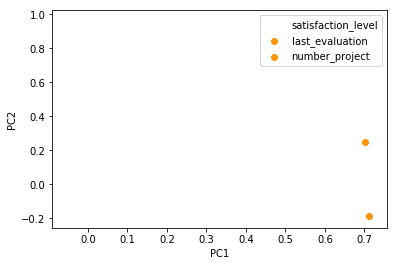

In [6]:
colors = [plt.cm.hsv(0.1 * 1, i) for i in range(len(features))]

for i in range(len(features)):
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(
        pca.components_[0, i],
        pca.components_[1, i],
        c=colors[i],
        label=features[i]
    )

plt.legend()

「`satisfaction_level`」は離れており、「`number_project`」と「`last_evaluation`」は横軸について対称な位置にある。

## 4. 主成分得点(データの可視化)

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


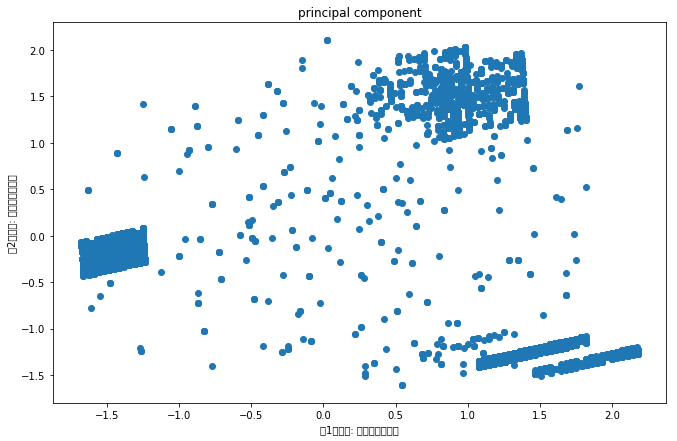

In [7]:
# 主成分をプロットする
plt.figure(figsize=(11,7))
plt.title('principal component')
plt.xlabel('第1主成分: できる社員指数')
plt.ylabel('第2主成分: 効率性・充実度')

plt.scatter(
    transformed[:, 0],
    transformed[:, 1],
)

# グラフを表示する
plt.show()

上記のデータの散布図より、「できる&充実している社員」と「できる&退屈社員」と「できない社員」に別れることがわかる。

## 主成分によるクラスタリング

$n$変数を第$k$主成分までに圧縮し、その寄与率が**<font color="red">0.8</font>**以上なら$n$変数を$k$個の合成変数に圧縮したことになる。これは、クラスタリングするベクトルの次元が多い場合に発生する**球面集中現象**問題を解決する手段となる。

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


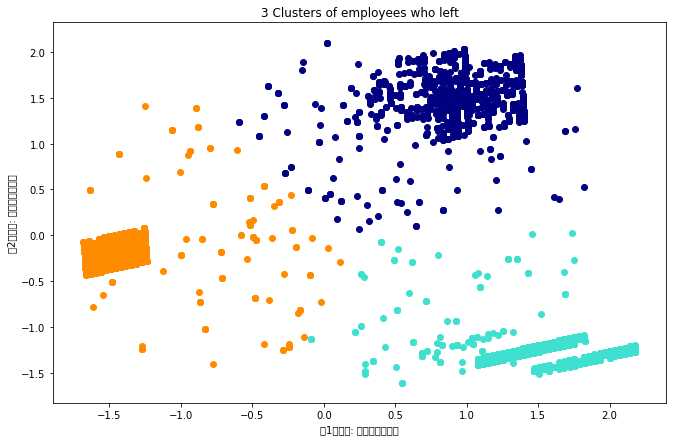

In [8]:
import matplotlib as mpl
from sklearn.cluster import KMeans

N_CLUSTER = 3

# 主成分でクラスタリング
km = KMeans(n_clusters=N_CLUSTER, random_state=0)
km_model = km.fit(transformed)

labels = km_model.labels_

# scater method → http://pythondatascience.plavox.info/matplotlib/%E6%95%A3%E5%B8%83%E5%9B%B3
plt.figure(figsize=(11,7))
plt.xlabel('第1主成分: できる社員指数')
plt.ylabel('第2主成分: 効率性・充実度')
plt.title('3 Clusters of employees who left')

colors = ['navy', 'turquoise', 'darkorange']

for i in range(transformed.shape[0]):
    plt.scatter(
        transformed[i, 0],
        transformed[i, 1],
        color=colors[labels[i]]
    )

plt.show()

---
# 行列とベクトル表記による主成分分析

 - $p$ : 変数の個数,特徴量の数
 - $n$ : サンプルサイズ

$$
\boldsymbol {\mathrm {a}} = \left( \begin{matrix} { a }_{ 1 } \\ { a }_{ 2 } \\ \vdots  \\ { a }_{ p } \end{matrix} \right) ,\quad \boldsymbol {\mathrm {u}}_{i} = \left( \begin{matrix} { u }_{ i1 } \\ { u }_{ i2 } \\ \vdots  \\ { u }_{ ip } \end{matrix} \right) 
$$

$u_{ij}$は、No.$i$のサンプル(特徴ベクトル)の変数$x_{j}$(特徴量)の値を用いて標準化したもの
$$
u_{ij} = \frac {x_{ij} - \bar {x}_{j}}{ {\sigma}_{{x}_{j}} }
$$

第1主成分を
$$
z_{1} = a_{1}u_{1} + a_{2}u_{2} + \cdots + a_{p}u_{p}
$$
と定義すると、No.$i$のサンプルの主成分得点は次のように表現できる。
$$
z_{i1} = a_{1}u_{i1} + a_{2}u_{i2} + \cdots + a_{p}u_{ip}\\
= \boldsymbol{\mathrm {a}}^{T} \boldsymbol {\mathrm {u}}_{i}\\
= \boldsymbol {\mathrm {u}}_{i}^{T} \boldsymbol {\mathrm {a}}
$$

これより$z_{1}$の分散を考える。
$$
V_{z_{1}} = \frac {1}{n - 1} \sum _{i=1}^{n}{\left( z_{i1} - {\bar {z}}_{1} \right)^{2}}\\
= \frac {1}{n - 1} \sum _{i=1}^{n}{ { z_{i1} }^{2}}\\
= \frac {1}{n - 1} \sum _{i=1}^{n}{\left( {\boldsymbol {\mathrm {a}}}^{T} {\boldsymbol {\mathrm {u}}_{i}} \right)\left( {\boldsymbol {\mathrm {u}}_{i}}^{T} {\boldsymbol {\mathrm {a}}} \right)}\\
= {\boldsymbol {\mathrm {a}}}^{T} \left( \frac {1}{n - 1} \sum _{i=1}^{n}{ {\boldsymbol {\mathrm {u}}}_{i} {\boldsymbol {\mathrm {u}}}_{i}^{T} } \right) \boldsymbol {\mathrm {a}}\\
= {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} \quad (9.40)
$$

ここで、$\boldsymbol {\mathrm {R}}$は相関係数行列(共分散行列)である。
$$
{\boldsymbol {\mathrm {u}}}_{i} {\mathrm {u}}_{i}^{T} = \begin{bmatrix} { u }_{ i1 } \\ { u }_{ i2 } \\ \vdots  \\ { u }_{ ip } \end{bmatrix}\left[ \begin{matrix} { u }_{ i1 } & { u }_{ i2 } & \cdots  & { u }_{ ip } \end{matrix} \right] =\begin{bmatrix} { { u }_{ i1 } }^{ 2 } & { u }_{ i1 }{ u }_{ i2 } & \cdots  & { u }_{ i1 }{ u }_{ ip } \\ { u }_{ i2 }{ u }_{ i1 } & { { u }_{ i2 } }^{ 2 } & \cdots  & { u }_{ i2 }{ u }_{ ip } \\ \vdots  & \vdots  & \ddots  & \vdots  \\ { u }_{ ip }{ u }_{ i1 } & { u }_{ ip }{ u }_{ i2 } & \cdots  & { { u }_{ ip } }^{ 2 } \end{bmatrix} \quad (9.41)
$$

上式(9.40)の分散$V_{z_{1}}$の最大化において、制約条件
$$
a_{1}^{2} + a_{2}^{2} + \cdots + a_{p}^{2} = {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {a}} = 1\quad (9.42)
$$
を設ける。

> $$
\max { V_{z_{1}} = {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} }\\
s.t. \quad = {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {a}} = 1
$$

ラグランジュの未定乗数法を用いて、
$$
f\left( \boldsymbol {\mathrm {a}}, \lambda \right) = {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} - \lambda \left( {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {a}} - 1 \right) \quad (9.43)
$$
とおいて、これをベクトル$\boldsymbol {\mathrm {a}}$により微分して(サイエンス社「多変量解析法入門 3.3節」を参照)0とおく。
$$
\frac {\partial f}{\partial \boldsymbol {\mathrm {a}}} = 2 \boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} - 2 \lambda \boldsymbol {\mathrm {a}} = 0 \quad (9.44)
$$

これより、
$$
\boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} = \lambda \boldsymbol {\mathrm {a}} \quad (9.45)
$$
を得る。このことから、第1主成分の係数は、(9.45)式の固有値問題をといて、最大固有値に対応する(長さ1の、ノムル1の)固有ベクトルを求めればよいことがわかる。

(9.45)式に左から$\boldsymbol {\mathrm {a}}^{T}$をかければ、(9.42)式を用いることにより、
$$
{\boldsymbol {\mathrm {}a}}^{T} \boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} = \lambda {\boldsymbol {\mathrm {a}}}^{T} \boldsymbol {\mathrm {a}} = \lambda
$$
を得る。また、式(9.40)より
$$
V_{z_{1}} = {\boldsymbol {\mathrm {}a}}^{T} \boldsymbol {\mathrm {R}} \boldsymbol {\mathrm {a}} = \lambda
$$
となる。

次に、第2主成分の導出を考える。